In [15]:

%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [16]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

In [4]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='211027_mouse.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 10775.46 MiB, increment: 10578.47 MiB
loaded @220824.10:43:58
took 16.19-s to load data


In [5]:
# annotate metadata
WT = ['7202', '72921', '72922',   #5wk
      '22018', '2061', '2062',    #12wk
      '6569', '65701', '65702',   #18wk
      '1974', '2020', '20202',    #24wk
      '5812', '5822', '58232']   #30wk 58231 -> 5822
SCA1 = ['7294', '72931', '72932', #5wk
        '22019', '2063', '2065',  #12wk
        '6571', '65731', '65732', #18wk
        '1589', '2021', '20212',  #24wk
        '58231', '58241', '58242'] #30wk 5822 -> 58231
genotype = []
for i in adata.obs['batch'] : # verbose loop for quality-assurance
    if i in WT :
        genotype.append('WT')
    elif i in SCA1 :
        genotype.append('SCA1')
    else :
        raise ValueError('Encountered unclassifiable genotype for animal {}'.format(i))
adata.obs['genotype']=genotype


print(adata)

AnnData object with n_obs × n_vars = 318312 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'sub1', 'sub2', 'sub3', 'sub4'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'louvain', 'neighbors', 'pca', 'sub1_colors', 'sub2_colors', 'sub3_colors', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [6]:
# save data objects
adata.write(os.path.join(dfp,'220824_mouse_genotype_corrected.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

... storing 'genotype' as categorical


saved @220824.10:46:01


In [3]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220824_mouse_genotype_corrected.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 10775.48 MiB, increment: 10578.47 MiB
loaded @220824.11:07:14
took 11.32-s to load data


In [4]:
pc = adata[adata.obs['sub4']== 'PC',:]

In [5]:
pc.obs.sub3.value_counts(0)

Z+PC    1334
Z-PC     840
Name: sub3, dtype: int64

In [6]:
def phateumap(X,plot=None,recalculate=False,save=None,title=None,bbknn=True,cluster='batch',cmap=None) :
    """Plot or recalculate then plot
    
    Args:
        X (AnnData): subsetted AnnData object
        plot (ax object): optional. give ax object to plot in multiple for loop 
        save (str): optional. Save the plot with the full filepath indicated, otherwise return ax
    """
    if recalculate :
        # umap/louvain based off batch-balanced graph
        sc.tl.pca(X,n_comps=100)
        if bbknn:
            sc.external.pp.bbknn(X,batch_key='batch')
        else :
            sc.pp.neighbors(X,n_neighbors=30,n_pcs=100)
        sc.tl.umap(X)
        sc.tl.louvain(X,resolution=0.5)

        # compute PHATE
        G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None

        phate_op = phate.PHATE(knn_dist='precomputed',
                               gamma=0,
                               n_jobs=-1)
        X.obsm['X_phate']=phate_op.fit_transform(G.K)
        
    if plot is not None :
        if not isinstance(plot,plt.Axes) :
            fig,ax=plt.subplots(1,2,figsize=(8,3))
        else :
            ax = plot
            
        if cluster=='louvain' :
            color = X.obs[cluster].astype(int)
        else :
            color = X.obs[cluster]
            
        if cmap is None :
            if cluster=='louvain':
                cmap = sns.color_palette('colorblind',len(X.obs[cluster].unique()))
                cmap = {v:cmap[i] for i,v in enumerate(np.unique(X.obs[cluster].astype(int)))}
            cmap = sns.color_palette('colorblind',len(X.obs['batch'].unique())) # problematic if n_batch > 12
            
        # pt_size 
#         s = 10*X.shape[0]*4.8602673147023086e-06 # based on s=0.2 for N=hdata.shape[0]

            
        scprep.plot.scatter2d(X.obsm['X_umap'],
                      c=color,
                      cmap=cmap,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax[0],
#                       s = s,
                      alpha=0.6,
                      title=title,
                      rasterized=True)
        scprep.plot.scatter2d(X.obsm['X_phate'],
                              c=color,
                              cmap=cmap,
                              ticks=None,
                              label_prefix='PHATE',
                              legend=True,
                              legend_loc=(1.01,0.1),
                              ax=ax[1],
#                               s = s,
                              alpha=0.6,
                              title=title,
                              rasterized=True)
        if save is not None :
            if '.pdf' in save :
                fig.savefig(save,dpi=300, bbox_inches='tight')
            else : 
                fig.savefig(save+'.pdf',dpi=300, bbox_inches='tight')
                
    return X

In [7]:
# aesthetics
try :
    adata.obs['genotype_timepoint']
except KeyError :
    adata.obs['genotype_timepoint']=[v + ' WT' if 'WT' in adata.obs['genotype'][i] else v + ' SCA1' for i,v in enumerate(adata.obs['timepoint'])]
    adata.obs['genotype_timepoint']=adata.obs['genotype_timepoint'].astype('category')
cmap_mouse = {'5wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[1], 
              '5wk SCA1':sns.cubehelix_palette(8)[1], 
              '12wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[2], 
              '12wk SCA1':sns.cubehelix_palette(8)[2], 
              '18wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[3], 
              '18wk SCA1':sns.cubehelix_palette(8)[3], 
              '24wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[4], 
              '24wk SCA1':sns.cubehelix_palette(8)[4], 
              '30wk WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[5], 
              '30wk SCA1':sns.cubehelix_palette(8)[5]}


In [17]:
## PC; higher neighbor and n_pcs

Y = pc
sc.tl.pca(Y,n_comps=100)
sc.external.pp.bbknn(Y,batch_key='batch',neighbors_within_batch=15, n_pcs=50)
sc.tl.umap(Y)
sc.tl.louvain(Y,resolution=0.5)

NameError: name 'pc' is not defined

In [20]:
##Original - use for UMAP

cmap_sub3={ 'Z-PC': '#EE5264',
            'Z+PC': '#82c0e7',
}

Y.uns['sub3_colors']=np.array(list(cmap_sub3.values()),dtype=object)
Y.obs['sub3'].cat.reorder_categories(new_categories=list(cmap_sub3.keys()),
                                         inplace=True,ordered=True)

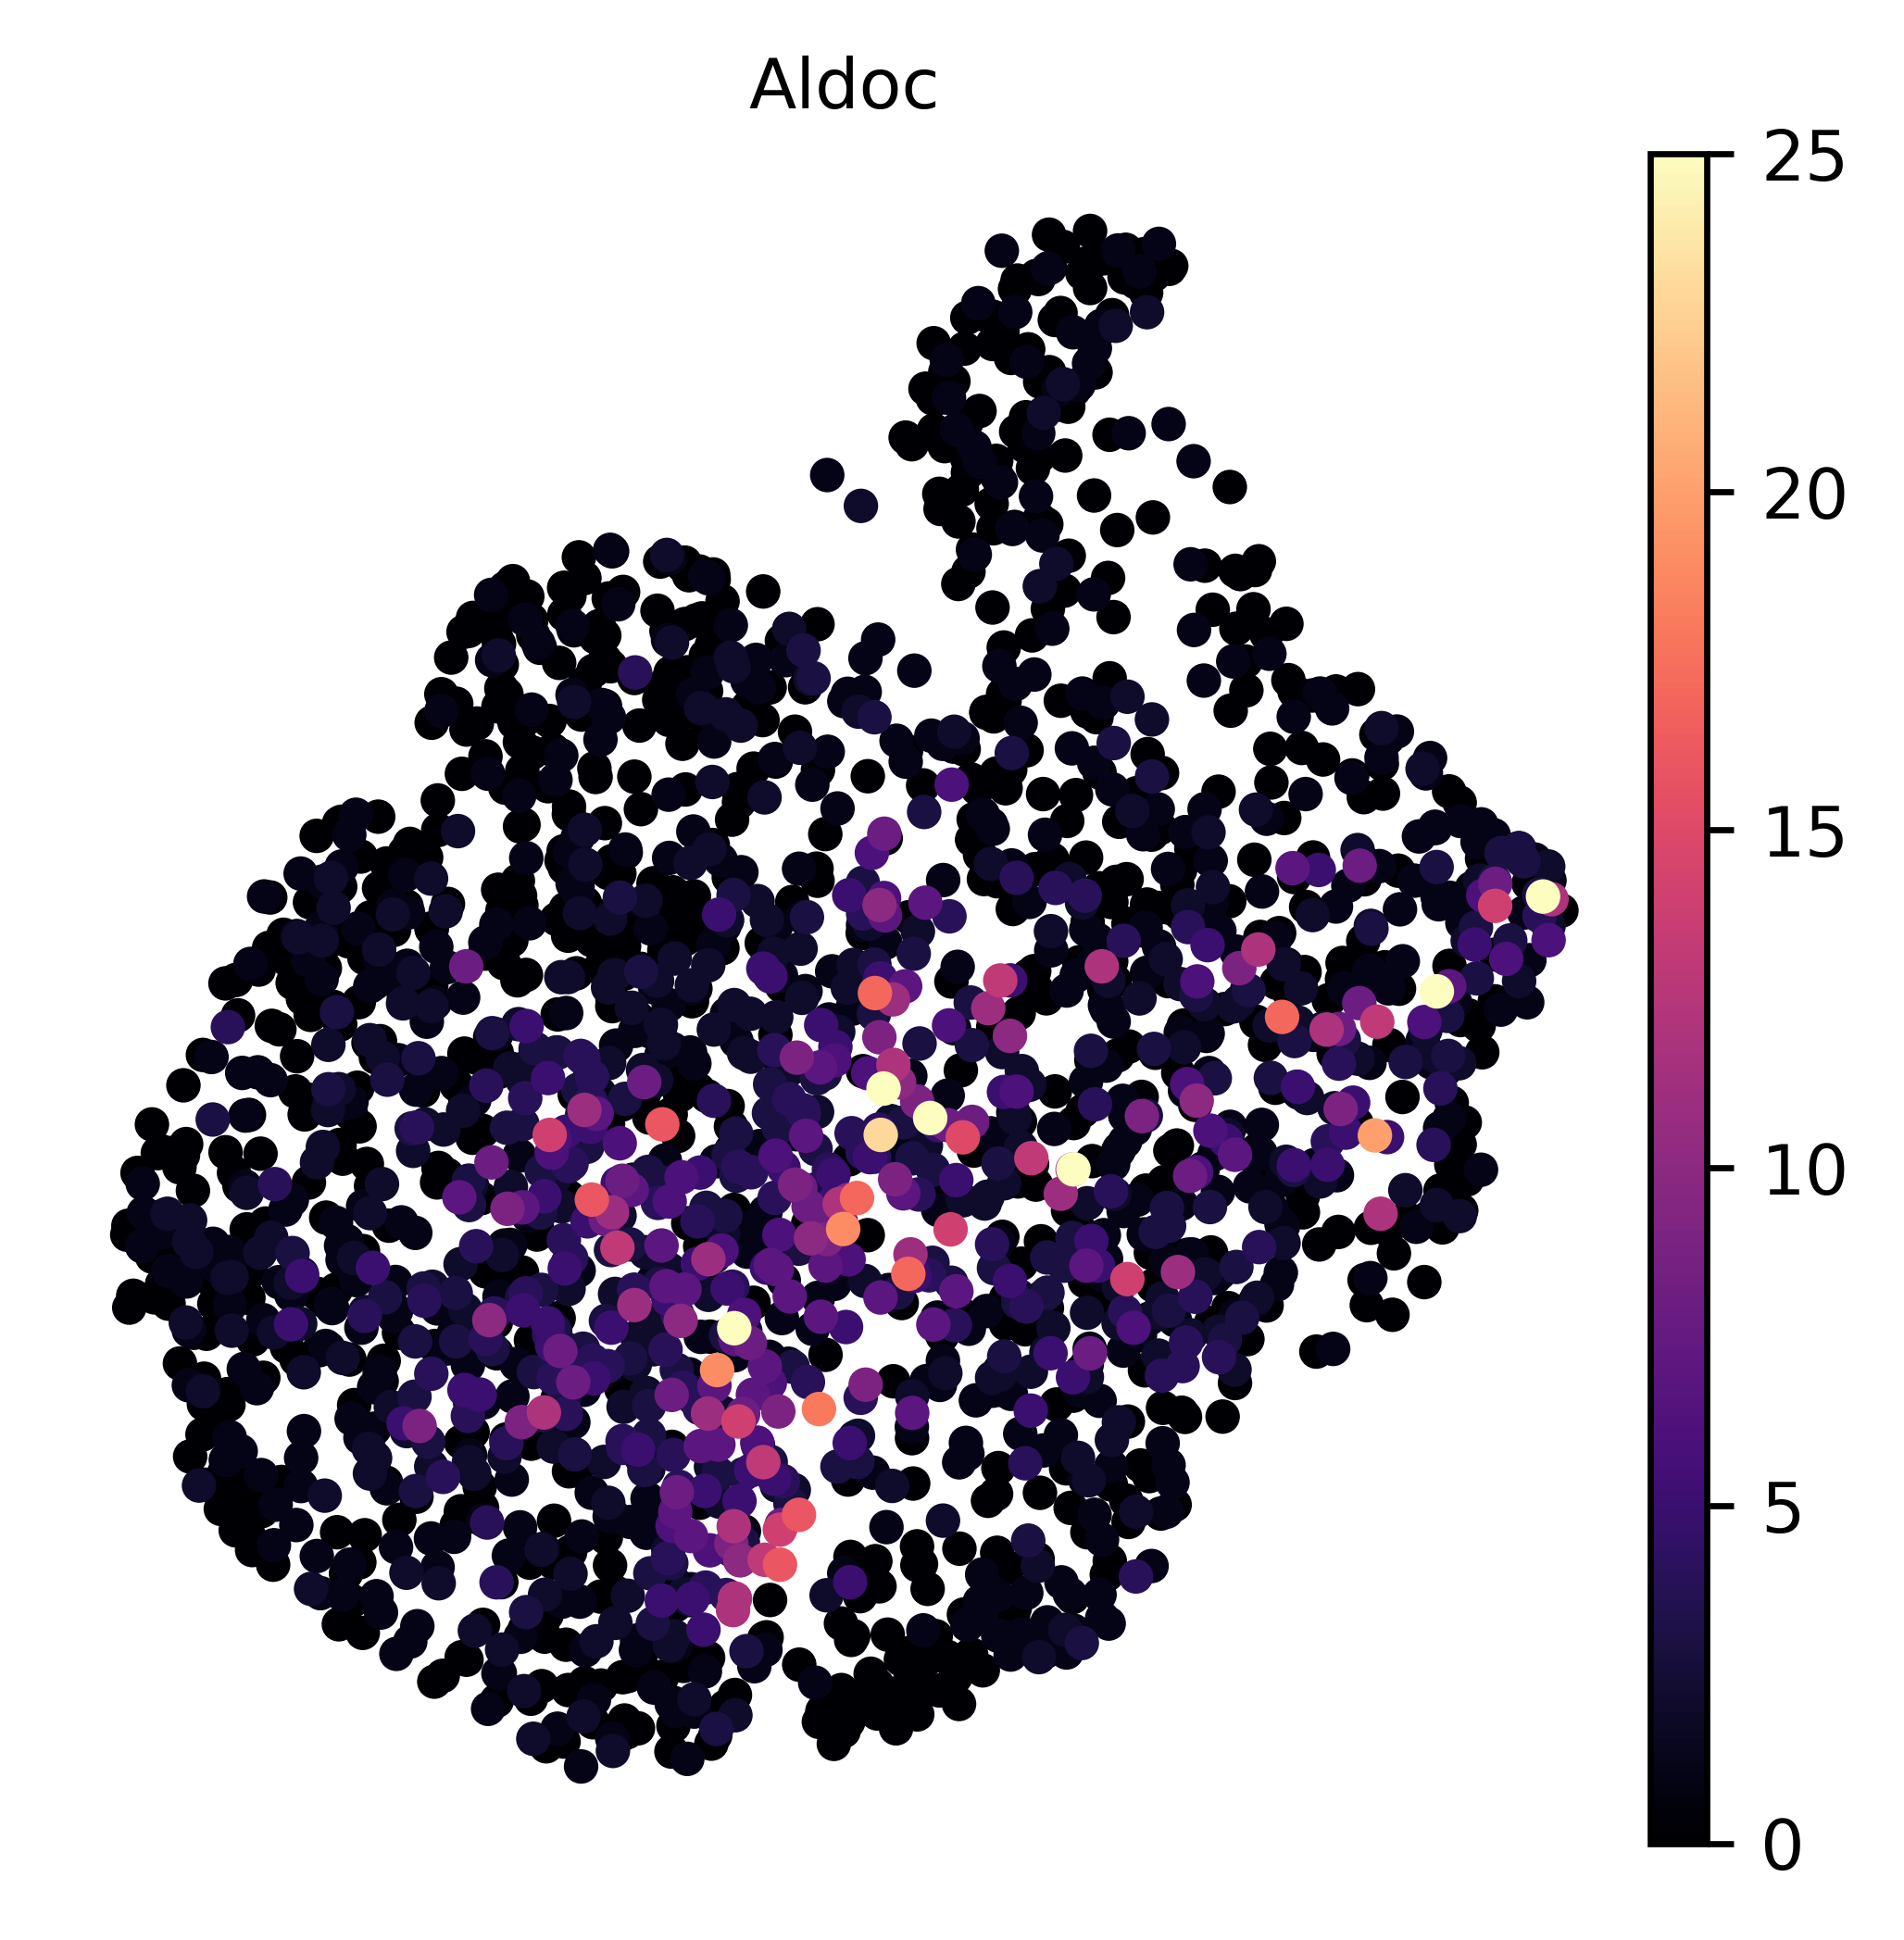

In [11]:
sc.pl.umap(Y, color ='Aldoc', size = 80,
           vmax = 25, 
           cmap = 'magma',
           #layer = 'imputed_bbknn'
           save = '220824_ZPC_Aldoc.pdf'
          )

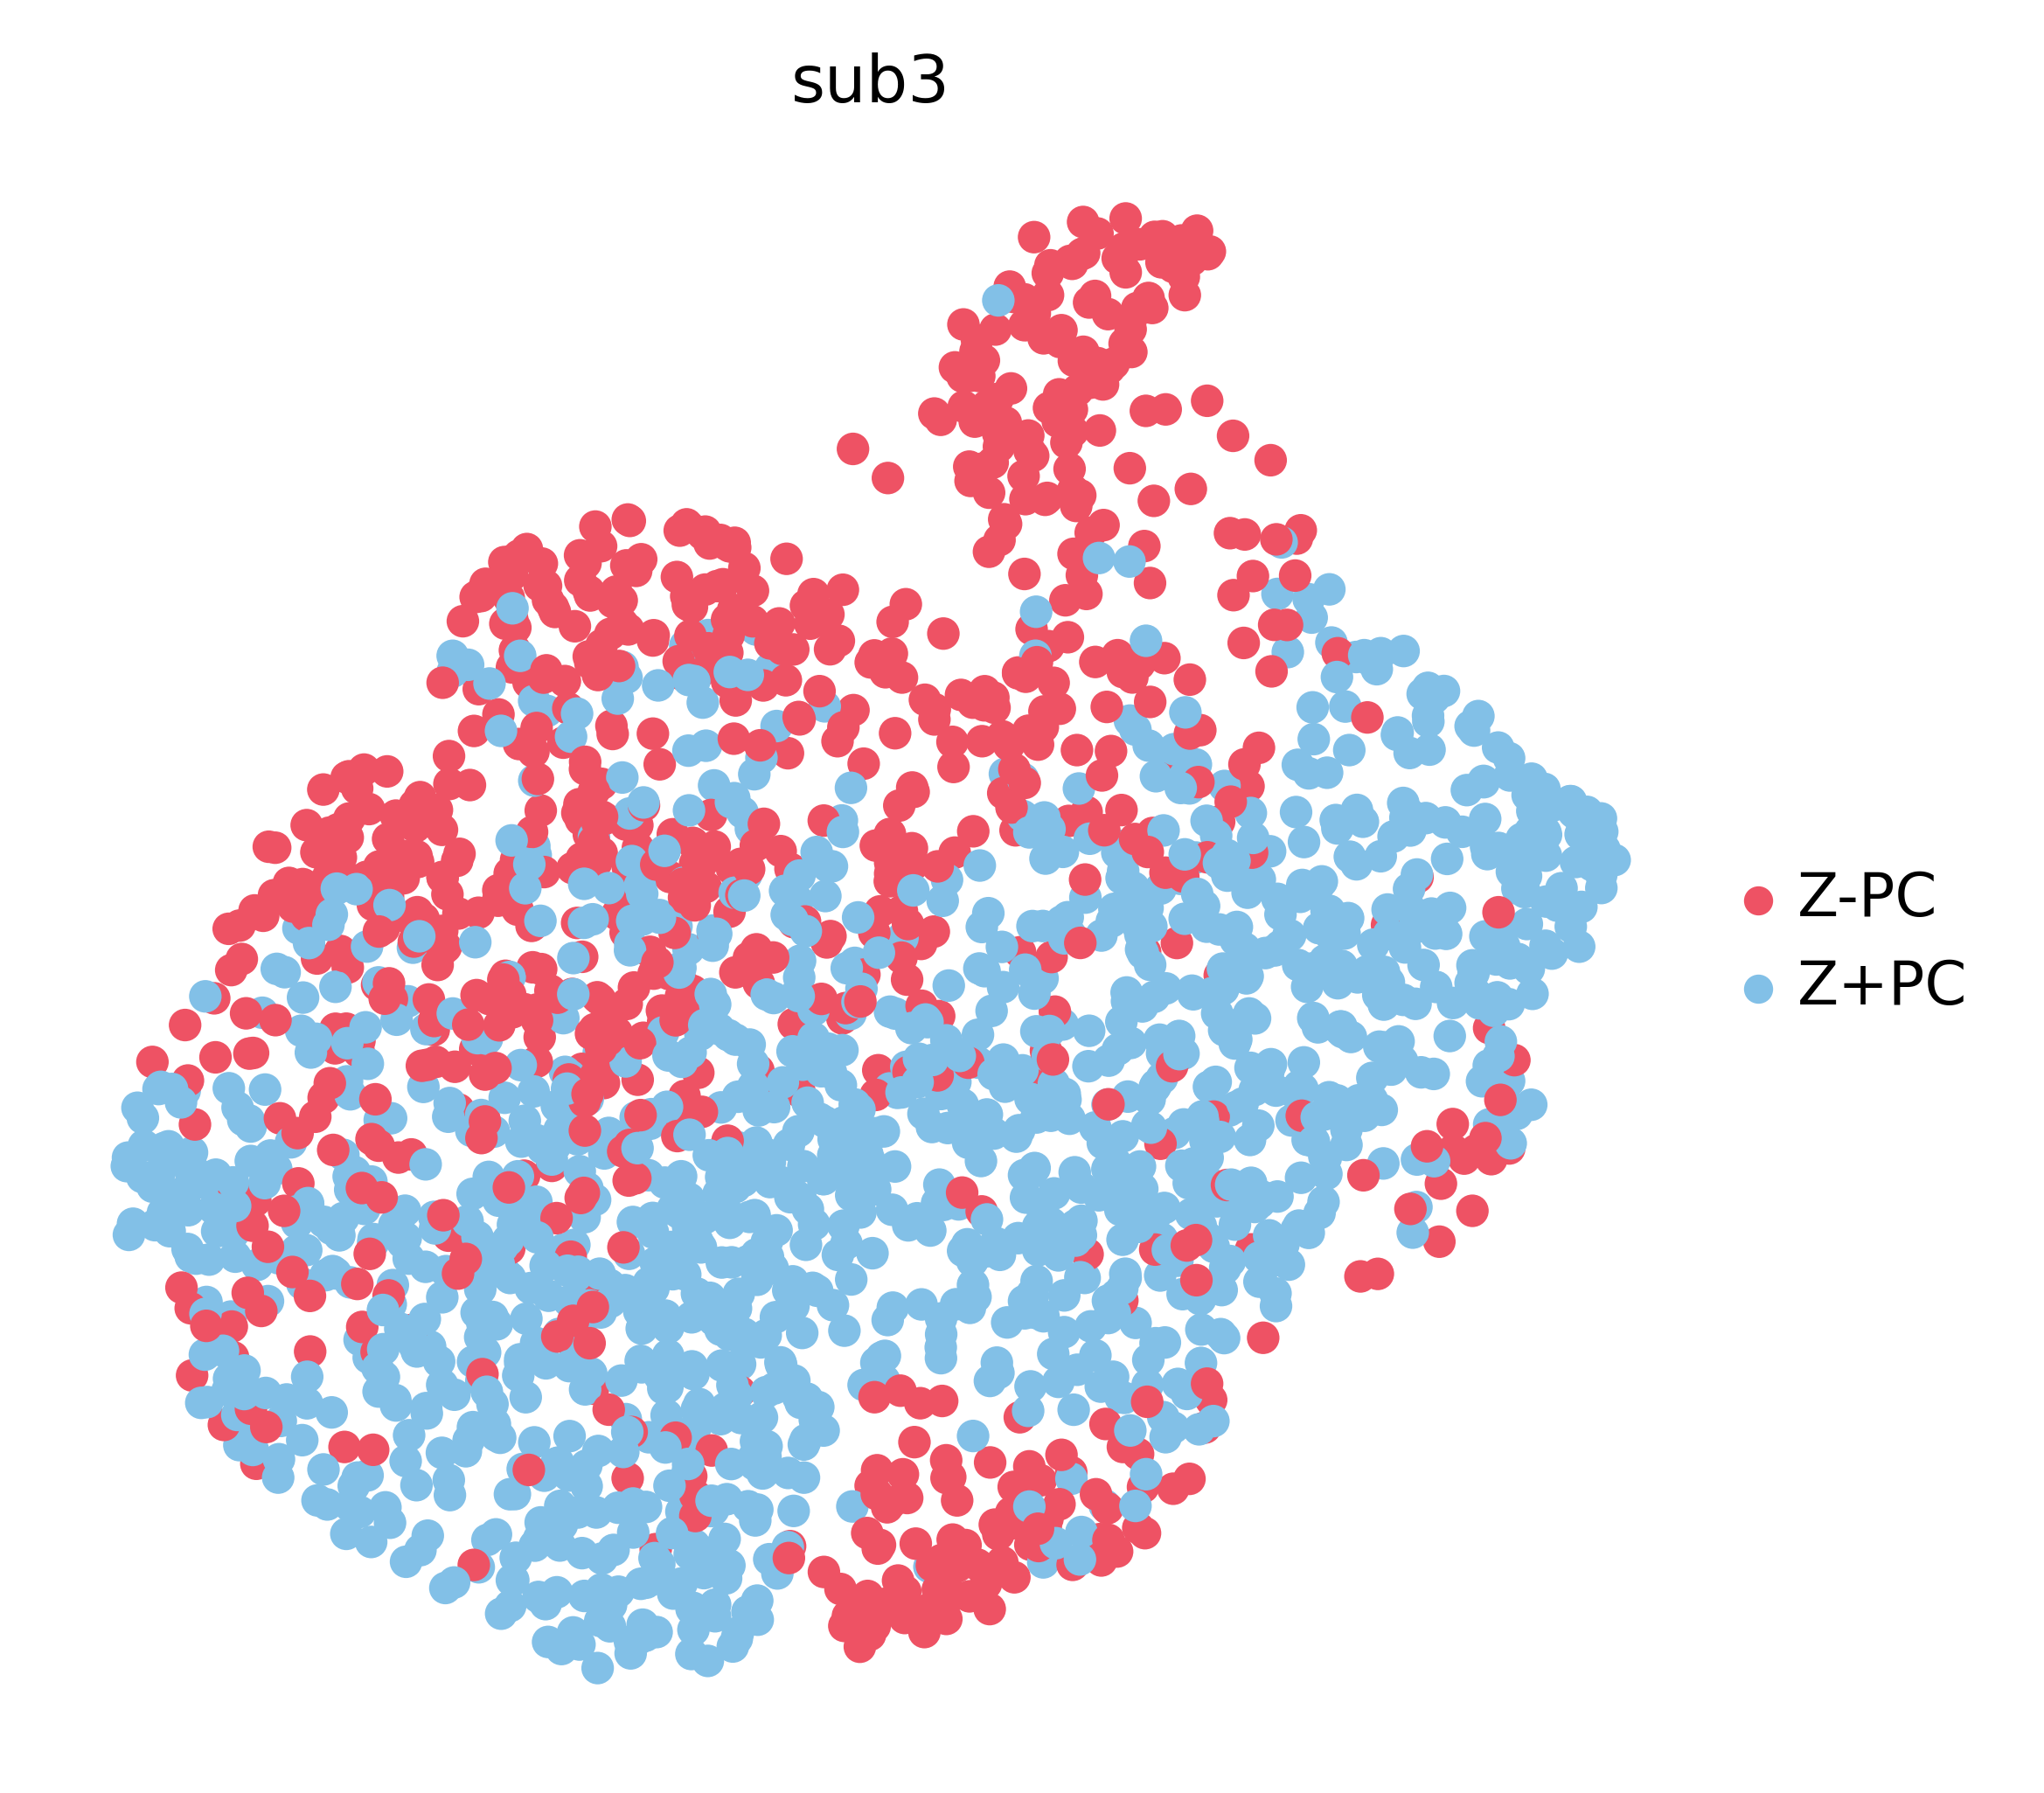

In [12]:
sc.pl.umap(Y, color ='sub3', size = 80,
           save = '220824_ZPC_genotype.pdf'
          )

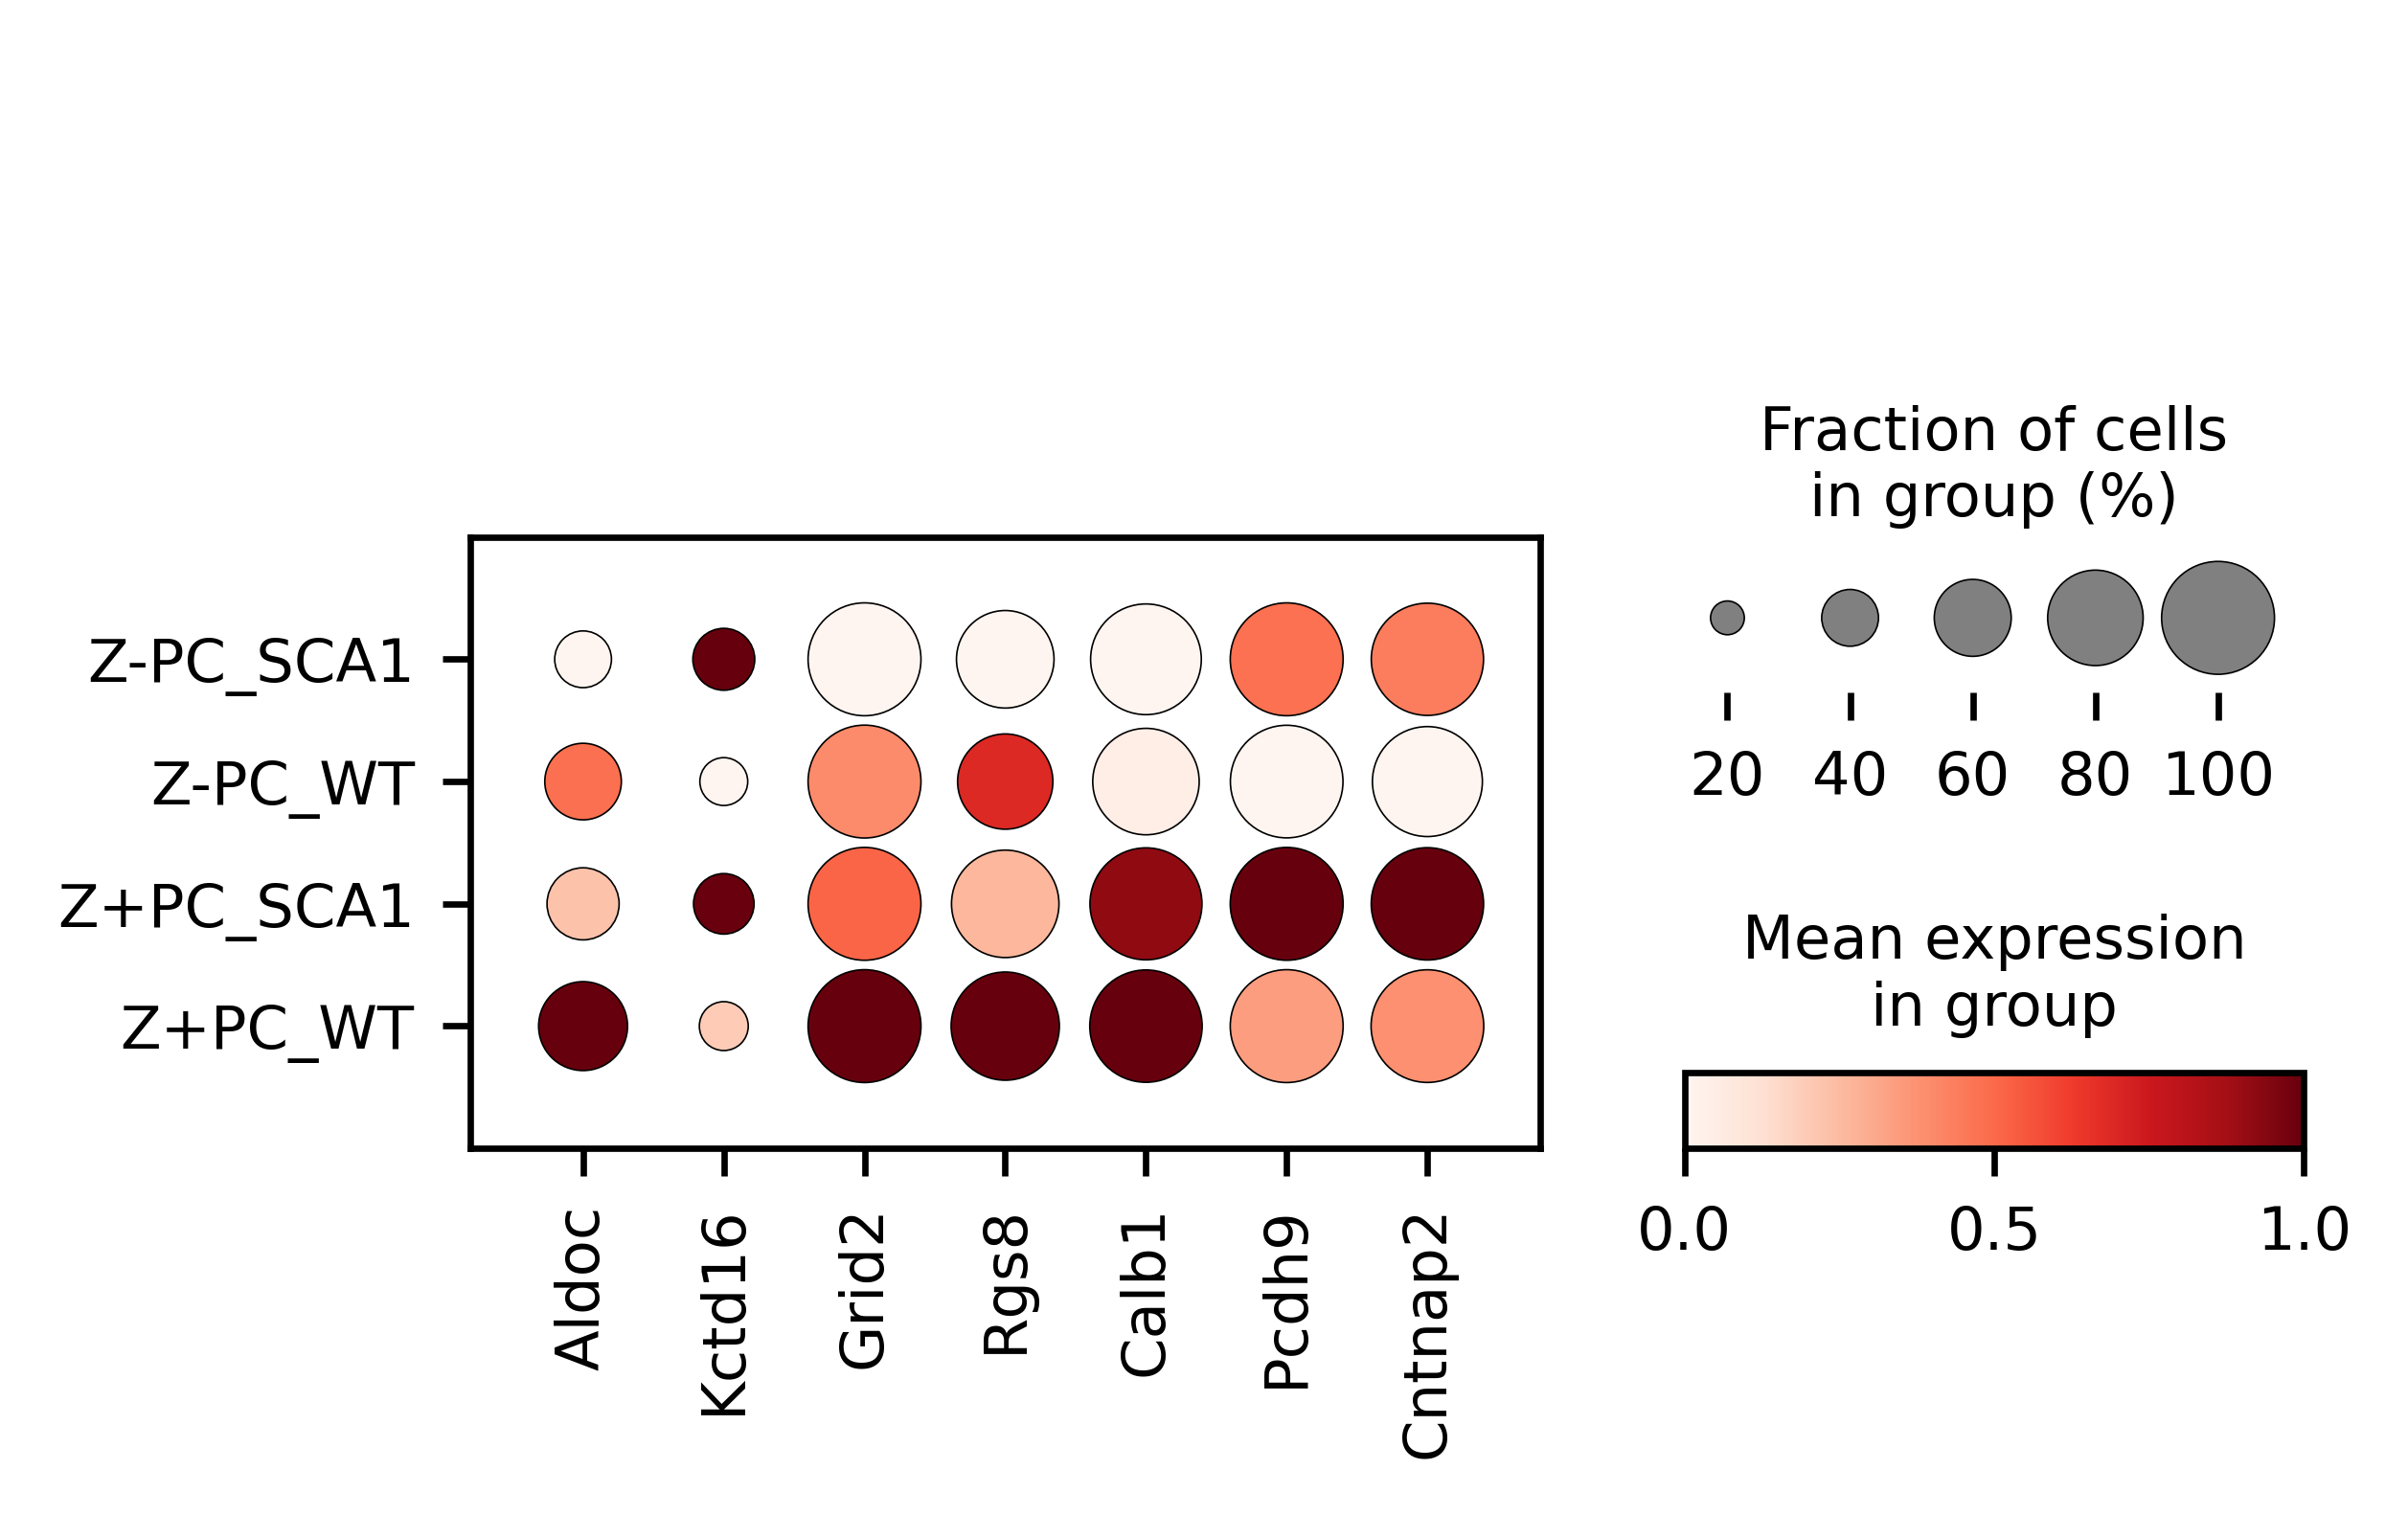

In [13]:
genes_dotplot = ['Aldoc', 'Kctd16','Grid2','Rgs8','Calb1','Pcdh9','Cntnap2']

sc.pl.dotplot(Y, genes_dotplot, groupby = ['sub3','genotype'], use_raw = True, standard_scale='var', var_group_rotation=90, save = '220824_ZPC_dotplot')

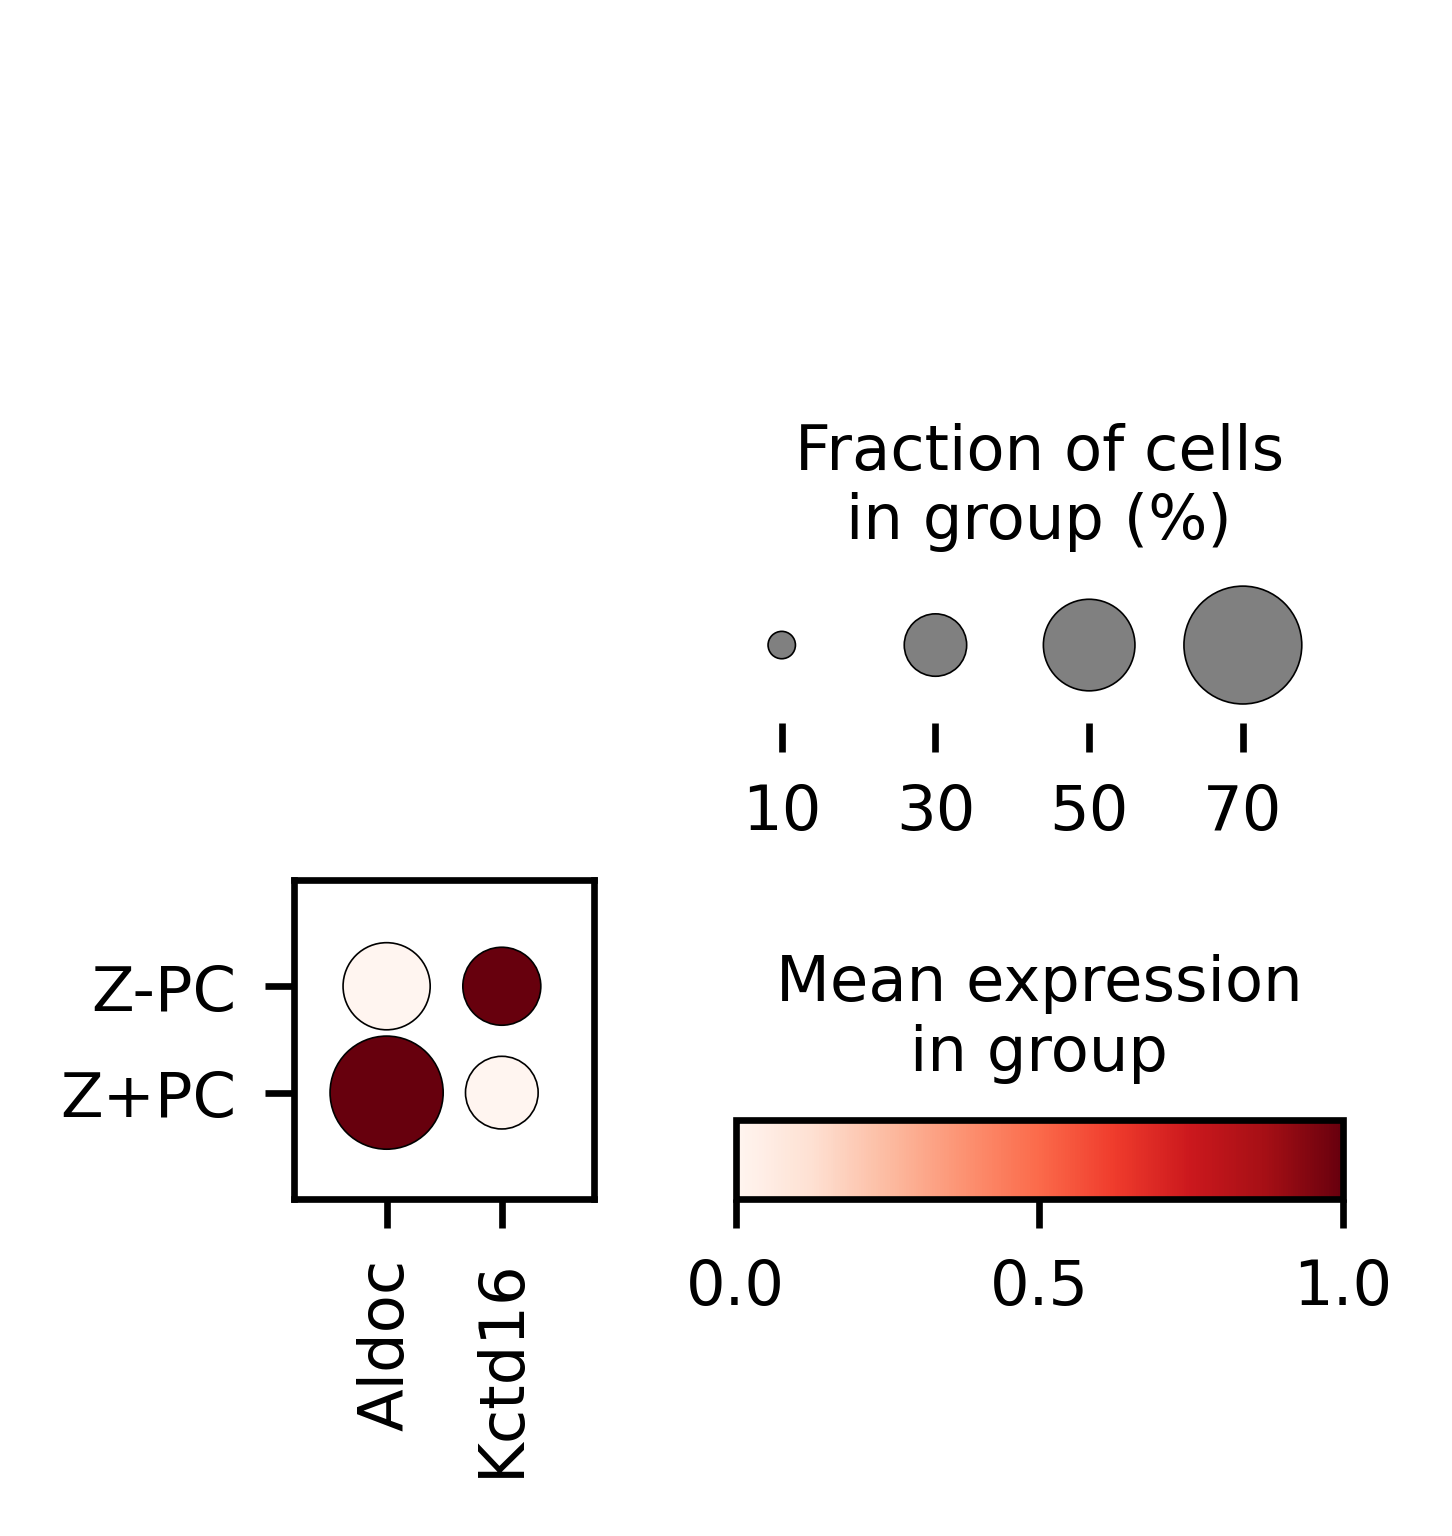

In [14]:
genes_dotplot = ['Aldoc', 'Kctd16']

sc.pl.dotplot(Y, genes_dotplot, groupby = ['sub3'], use_raw = True, standard_scale='var', var_group_rotation=90, save = '220824_ZPC_dotplot_Aldoc&Kctd16')

In [12]:
# save data objects
Y.write(os.path.join(dfp,'220824_PC_BBKNN.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

saved @220824.11:08:10


In [3]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220824_PC_BBKNN.h5ad' # for full, can maybe get away with ~300G
    %memit Y = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 418.15 MiB, increment: 219.11 MiB
loaded @220824.12:53:51
took 0.48-s to load data


In [18]:
## PC; higher neighbor and n_pcs

G = gt.Graph(data=Y.uns['neighbors']['connectivities']+sparse.diags([1]*Y.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
G.knn_max = None

phate_op = phate.PHATE(knn_dist='precomputed',
                        gamma=0,
                        n_jobs=-1)
Y.obsm['X_phate']=phate_op.fit_transform(G.K)

Y.write(os.path.join(dfp,'220824_mouse_PC_phate.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 2174 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.36 seconds.
  Calculated landmark operator in 15.68 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 2.40 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.26 seconds.
Calculated PHATE in 24.05 seconds.
saved @220824.13:17:39


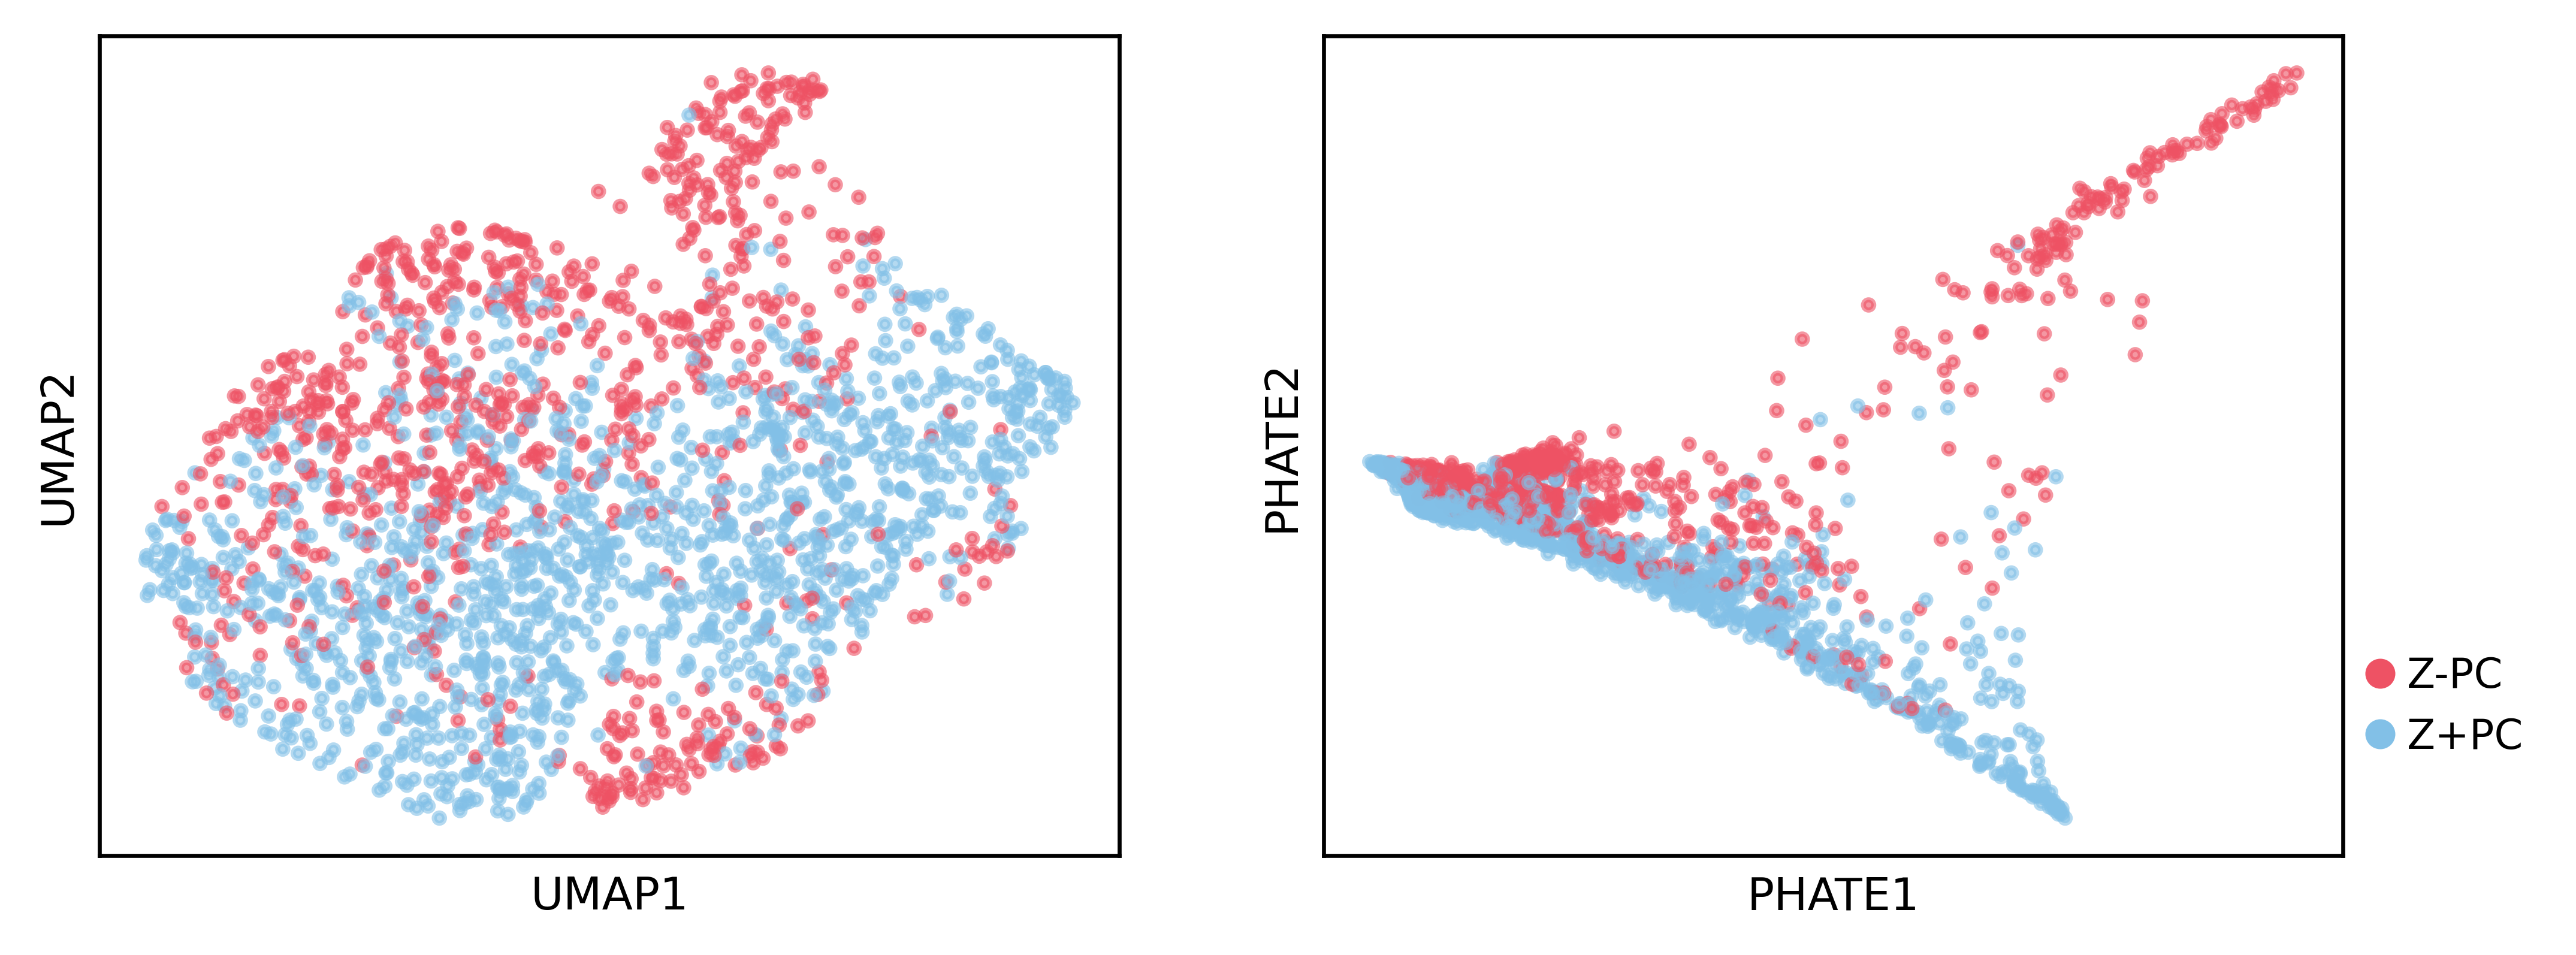

In [21]:
fig,ax=plt.subplots(1,2,figsize=(8,3))
scprep.plot.scatter2d(Y.obsm['X_umap'],
                      c=Y.obs['sub3'],
                      cmap=cmap_sub3,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax[0],
#                       s = s,
                      alpha=0.6,
#                      title=title,
                      rasterized=True)
scprep.plot.scatter2d(Y.obsm['X_phate'],
                              c=Y.obs['sub3'],
                              cmap=cmap_sub3,
                              ticks=None,
                              label_prefix='PHATE',
                              legend=True,
                              legend_loc=(1.01,0.1),
                              ax=ax[1],
#                               s = s,
                              alpha=0.6,
#                              title=title,
                              rasterized=True)


fig.savefig('220824_PC_Aldoc_phate.pdf',dpi=300, bbox_inches='tight')